In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode
import cv2
from tqdm import tqdm
import datetime
import random


In [ ]:
!unzip KITTI -d KITTI

Archive:  KITTI.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of KITTI or
        KITTI.zip, and cannot find KITTI.ZIP, period.


# **Import Dataset**

In [ ]:
from google.colab import drive
#Load Data
train_data_dir = "/content/KITTI/training/image_2/"
train_gt_dir = "/content/KITTI/training/gt_image_2/"

test_data_dir = "/content/KITTI/testing/"

In [ ]:
import os
# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")
os.listdir(train_data_dir)

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


['umm_000000.png',
 'umm_000021.png',
 'um_000092.png',
 'uu_000009.png',
 'umm_000088.png',
 'uu_000022.png',
 'um_000054.png',
 'um_000020.png',
 'umm_000042.png',
 'um_000077.png',
 'um_000038.png',
 'um_000001.png',
 'uu_000070.png',
 'uu_000060.png',
 'umm_000087.png',
 'umm_000019.png',
 'um_000084.png',
 'um_000090.png',
 'uu_000017.png',
 'umm_000043.png',
 'uu_000050.png',
 'uu_000000.png',
 'uu_000078.png',
 'umm_000016.png',
 'um_000057.png',
 'uu_000012.png',
 'umm_000055.png',
 'um_000041.png',
 'umm_000047.png',
 'umm_000034.png',
 'uu_000033.png',
 'uu_000073.png',
 'uu_000040.png',
 'umm_000065.png',
 'um_000010.png',
 'um_000014.png',
 'um_000060.png',
 'umm_000012.png',
 'um_000032.png',
 'uu_000003.png',
 'umm_000033.png',
 'um_000036.png',
 'umm_000035.png',
 'umm_000068.png',
 'uu_000027.png',
 'um_000065.png',
 'umm_000044.png',
 'um_000042.png',
 'um_000048.png',
 'uu_000035.png',
 'um_000017.png',
 'umm_000058.png',
 'uu_000074.png',
 'um_000011.png',
 'um_00002

In [ ]:
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 1234567890 #SOMETHING RANDOM HERE
input_shape = (IMG_SIZE,IMG_SIZE, N_CHANNELS) # SHOULD BE IMG_HEIGHT and IMG_WIDTH but lets see

In [ ]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    print(image)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    
    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# Generate dataset
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
#print(dir(all_dataset))
all_dataset = all_dataset.map(parse_image)
train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
print(dir(train_dataset))
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

Tensor("Identity:0", shape=(None, None, 3), dtype=uint8)
['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__debug_string__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__tf_tracing_type__', '__weakref__', '_abc_impl', '_add_trackable_child', '_add_variable_with_custom_getter', '_apply_debug_options', '_as_serialized_graph', '_checkpoint_dependencies', '_common_args', '_consumers', '_count', '_deferred_dependencies', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_get_legacy_saved_model_children', '_graph

# **Normalisation and Preprocessing**

In [ ]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [ ]:
# Function to view the images from the directory ---> Need Help
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

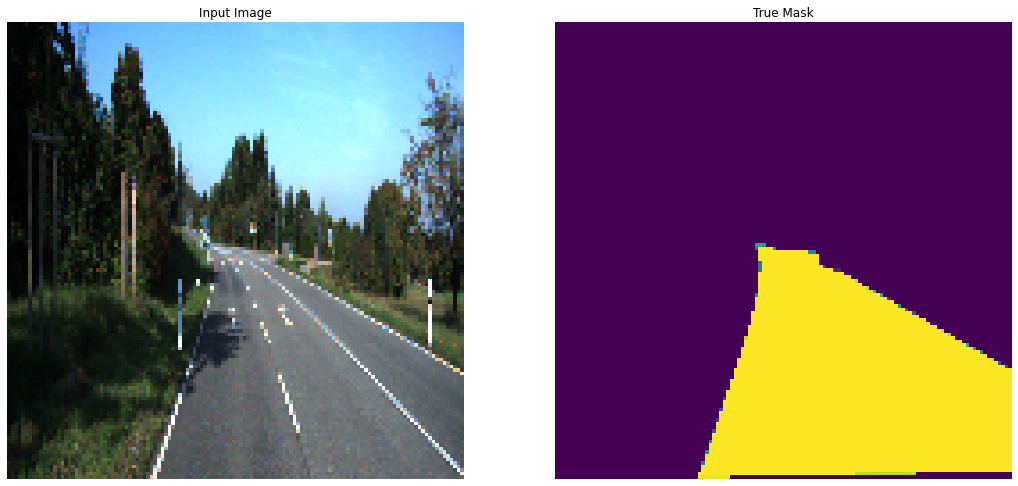

In [ ]:
  
# Define dataset?
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [ ]:
vgg16_model = VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
inputs = Input(input_shape)

# The VGG network
vgg16_model = VGG16(include_top = False, weights='imagenet', input_tensor = inputs)

# Encoding layers
s1 = vgg16_model.get_layer('block3_pool').output
s2 = vgg16_model.get_layer('block4_pool').output
s3 = vgg16_model.get_layer('block5_pool').output

# Decoder
u1 = UpSampling2D((2,2), interpolation='bilinear')(s3)
d1 = Concatenate()([u1,s2])
u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, s1])

#Output
u3 = UpSampling2D((8,8), interpolation= 'bilinear')(d2)

# The outputs is binary segmentation I suppose...
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)
model = Model(inputs, outputs, name = "VGG_FCN8")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "VGG_FCN8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

# **Training**

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

1/1 [==============================] - 9s 9s/step


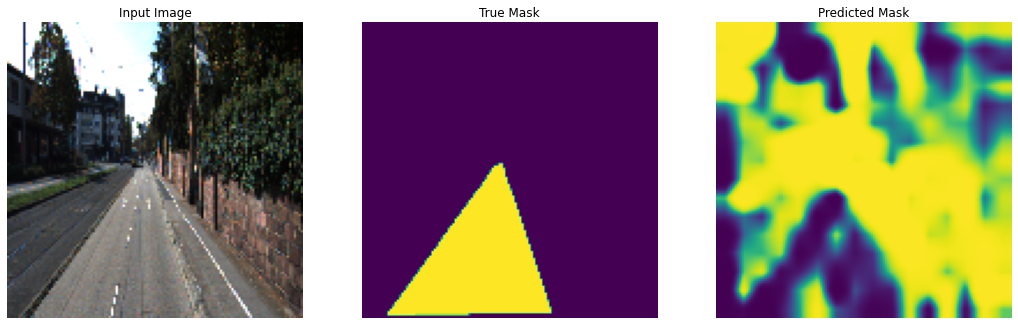

In [ ]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [ ]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]
        
# Set Variables
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE

1/1 [==============================] - 0s 48ms/step


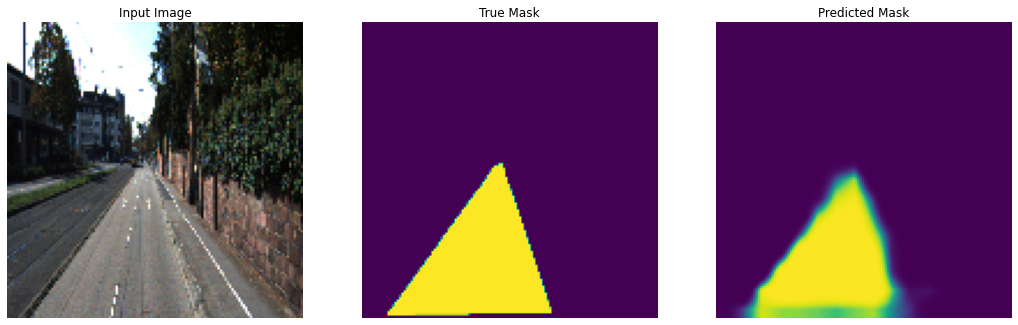


Sample Prediction after epoch 200



7/7 [==============================] - 7s 1s/step - loss: 0.0381 - mean_io_u: 0.4157


In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

In [ ]:
model.save('/content/Trained.h5')

# **Test Dataset**

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

Processing image : 0
1/1 [==============================] - 1s 707ms/step


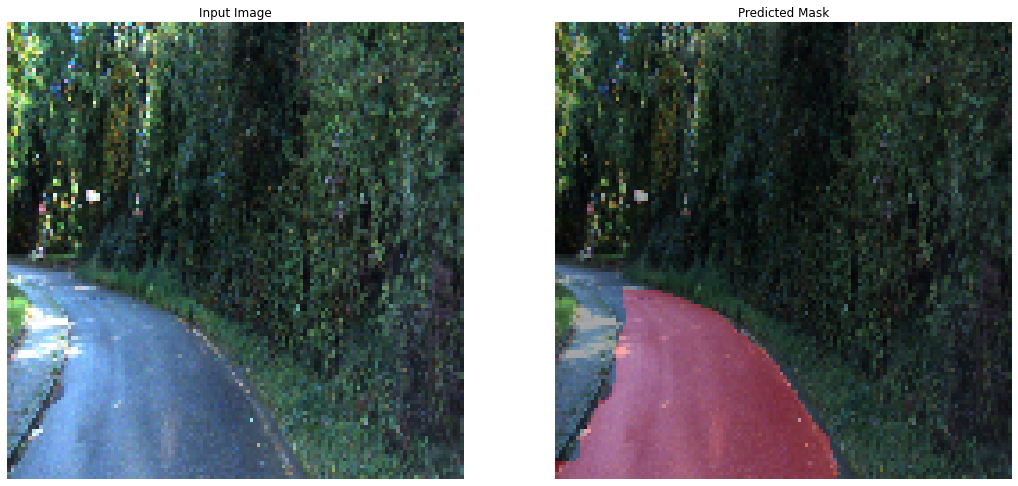

Processing image : 1
1/1 [==============================] - 0s 15ms/step


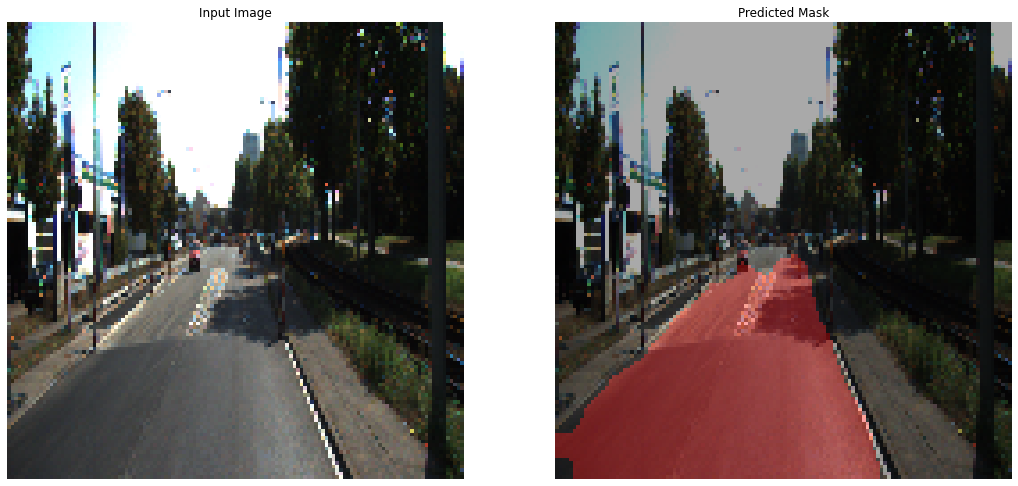

Processing image : 2
1/1 [==============================] - 0s 17ms/step


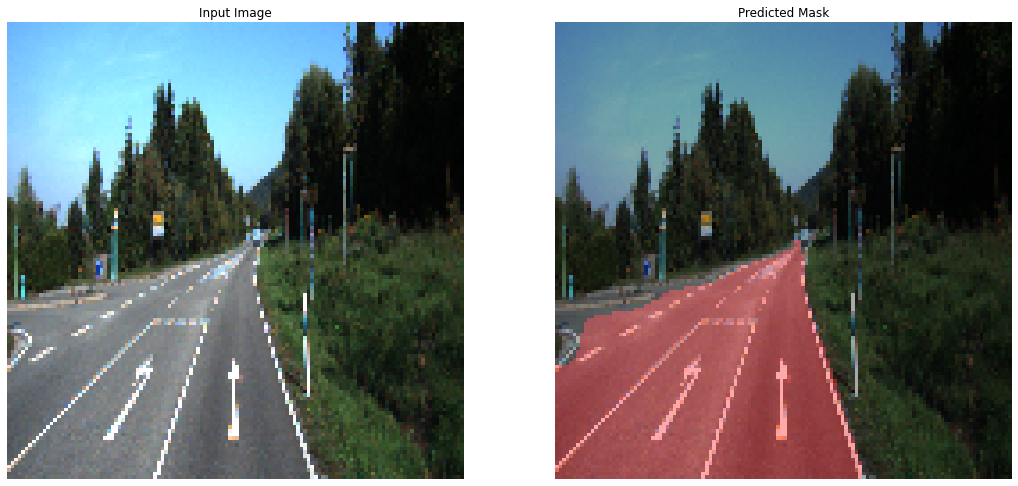

Processing image : 3
1/1 [==============================] - 0s 17ms/step


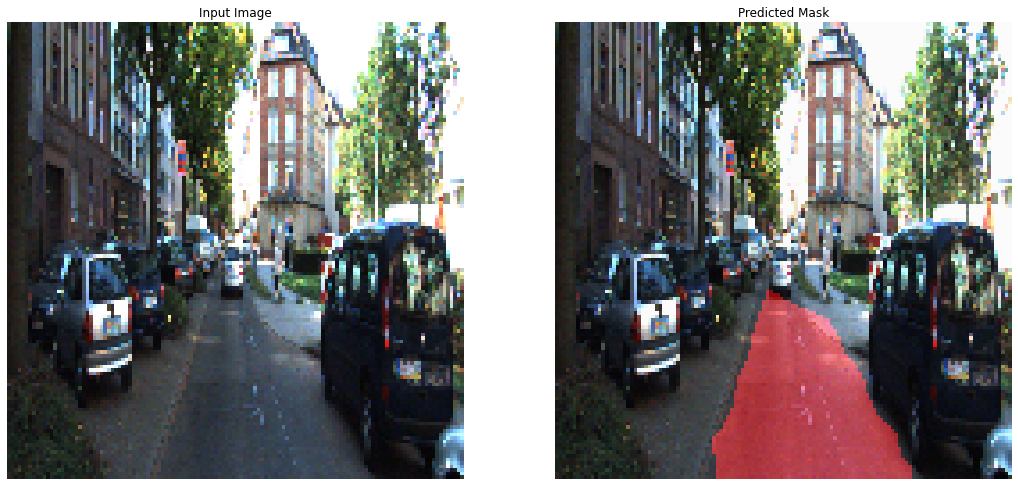

Processing image : 4
1/1 [==============================] - 0s 18ms/step


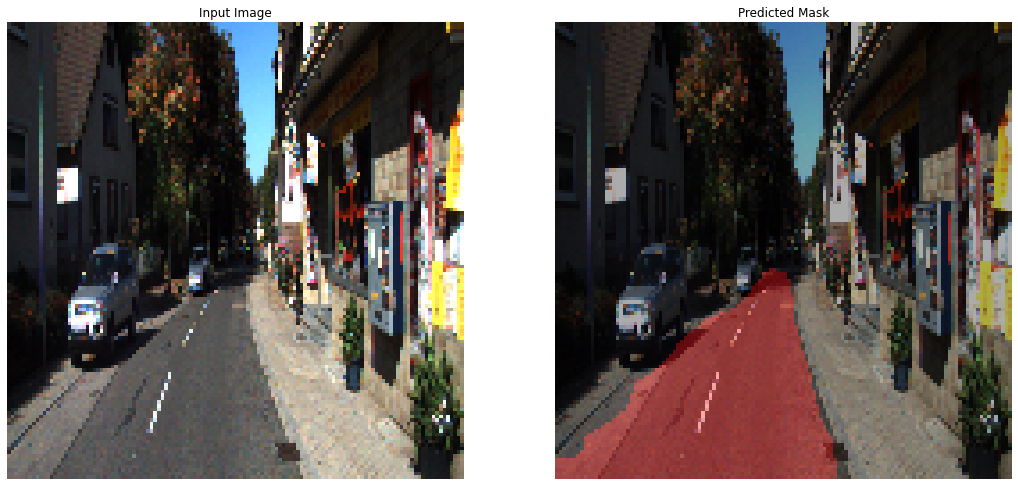

Processing image : 5
1/1 [==============================] - 0s 16ms/step


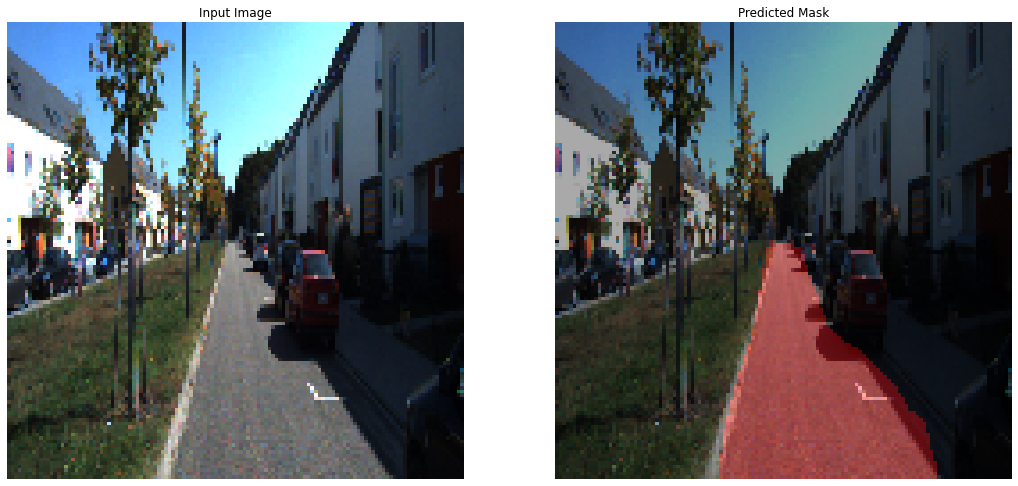

Processing image : 6
1/1 [==============================] - 0s 18ms/step


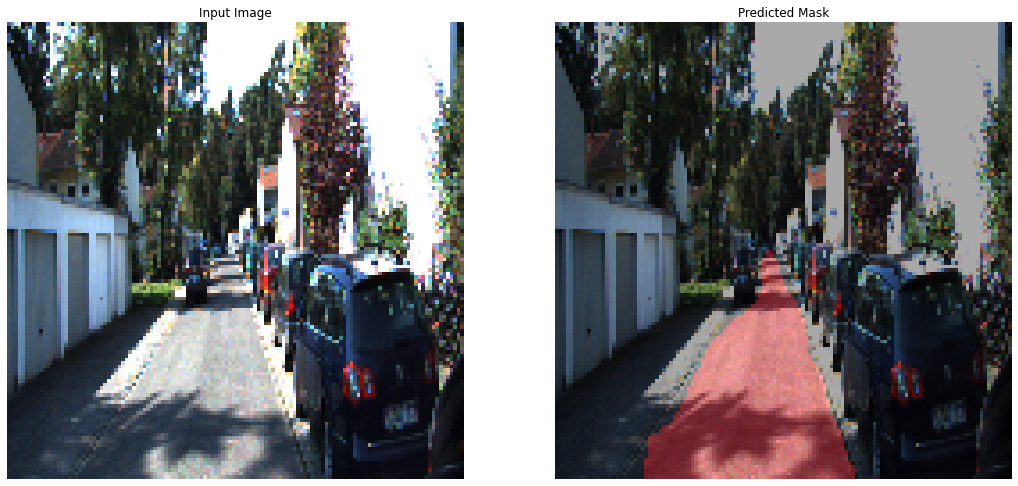

Processing image : 7
1/1 [==============================] - 0s 17ms/step


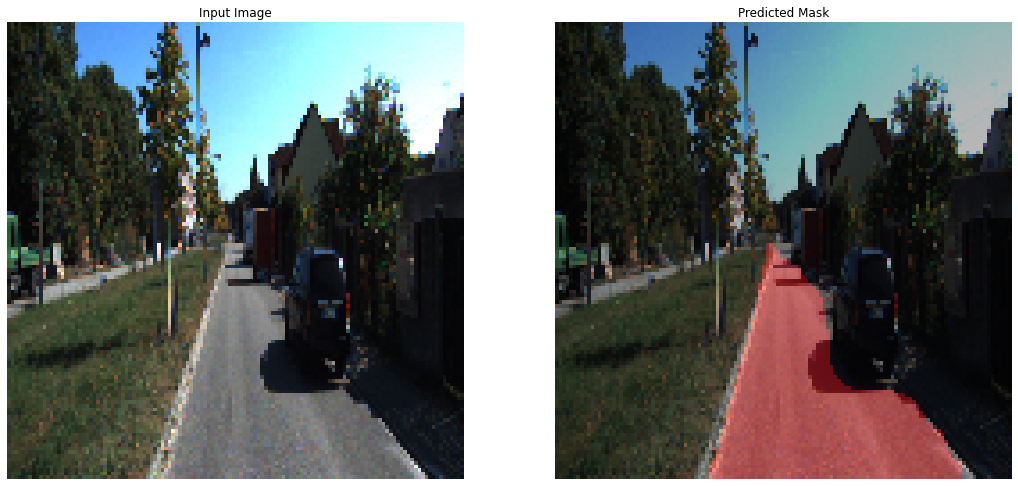

Processing image : 8
1/1 [==============================] - 0s 19ms/step


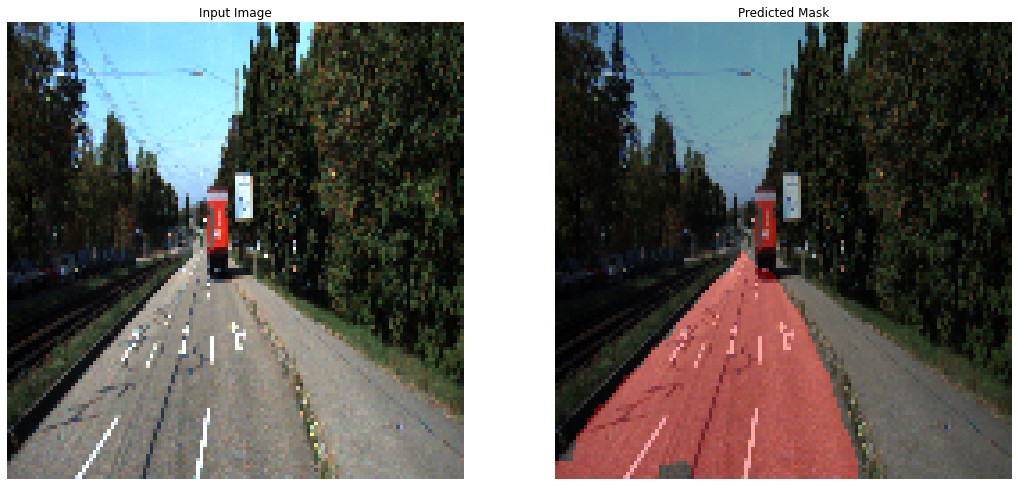

Processing image : 9
1/1 [==============================] - 0s 21ms/step


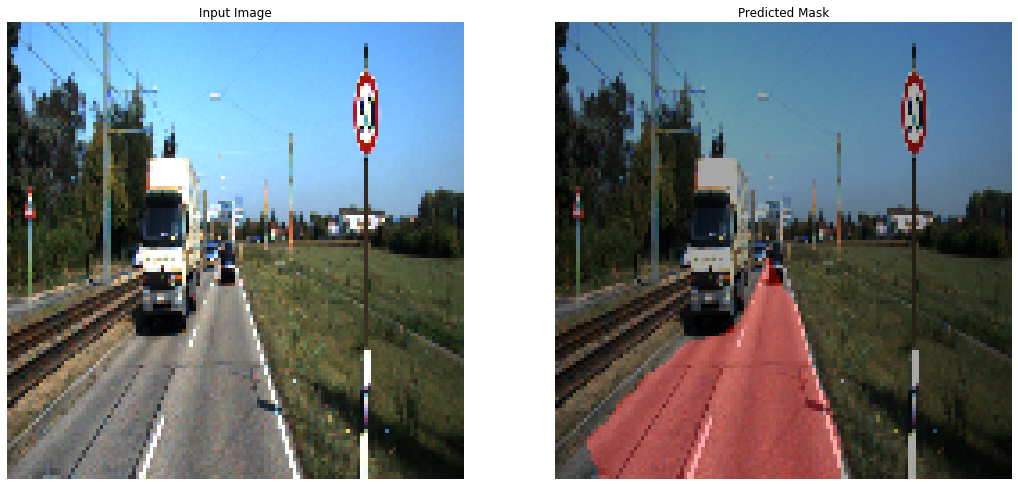

Processing image : 10
1/1 [==============================] - 0s 19ms/step


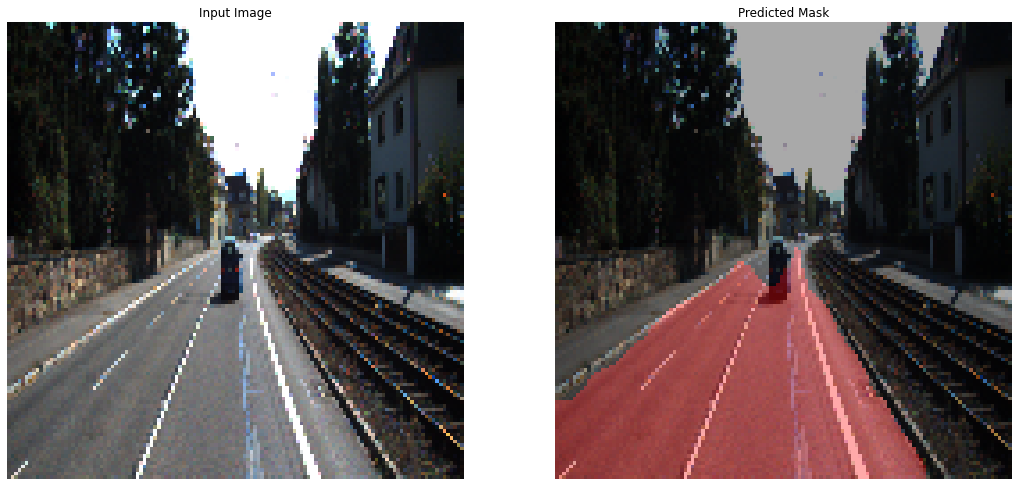

Processing image : 11
1/1 [==============================] - 0s 20ms/step


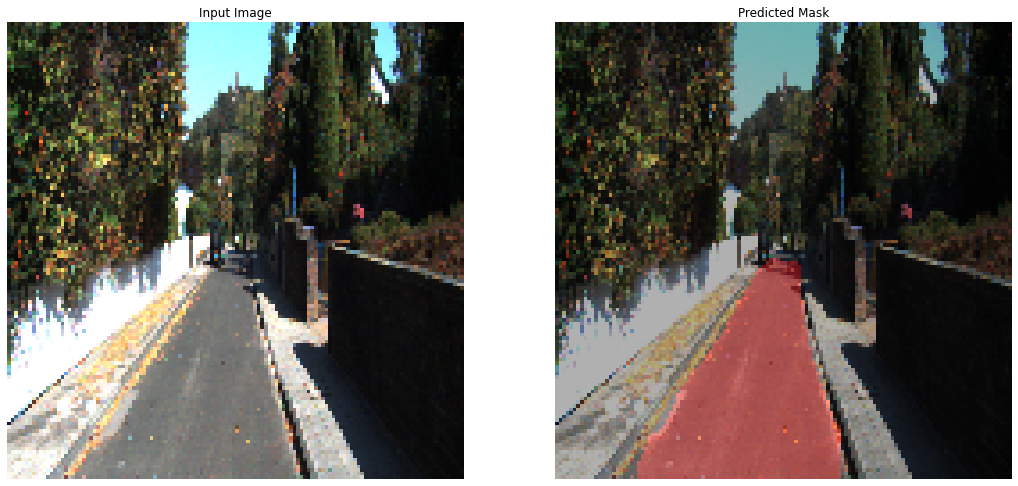

Processing image : 12
1/1 [==============================] - 0s 27ms/step


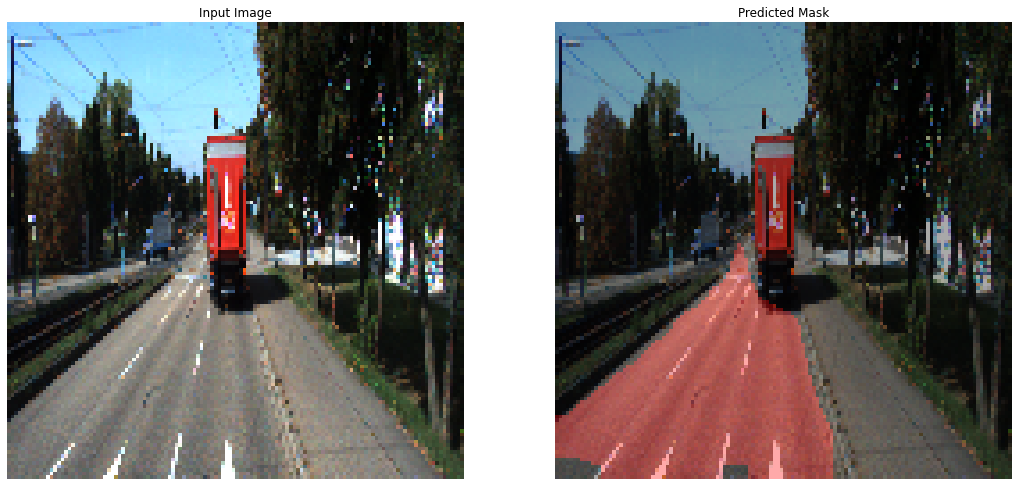

Processing image : 13
1/1 [==============================] - 0s 22ms/step


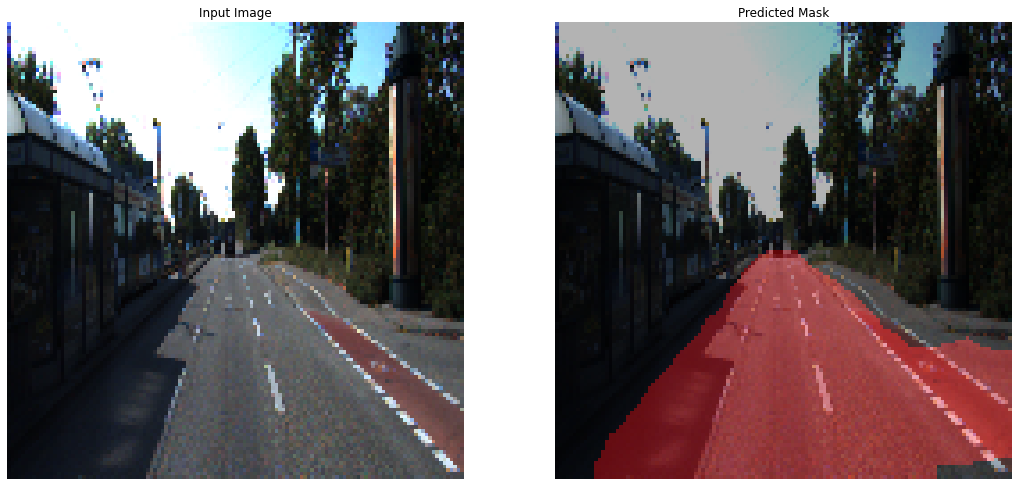

Processing image : 14
1/1 [==============================] - 0s 18ms/step


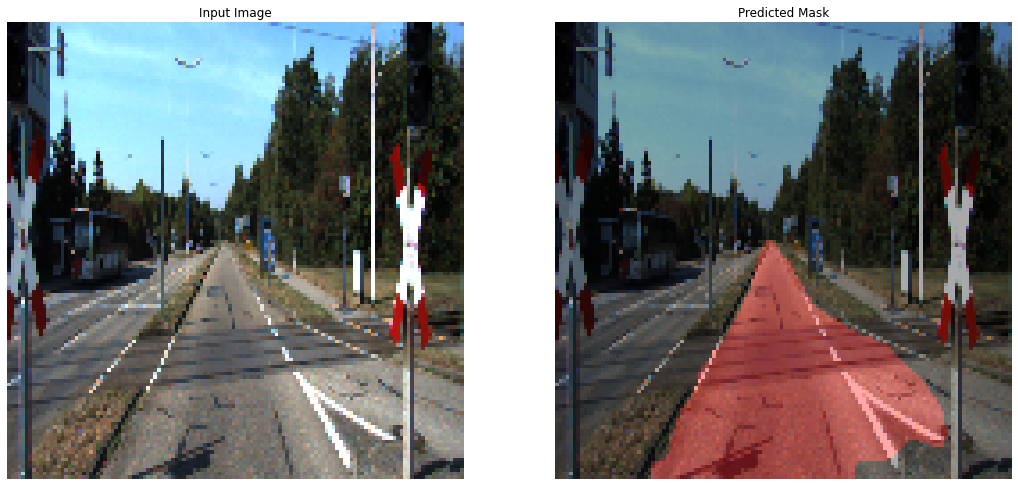

Processing image : 15
1/1 [==============================] - 0s 21ms/step


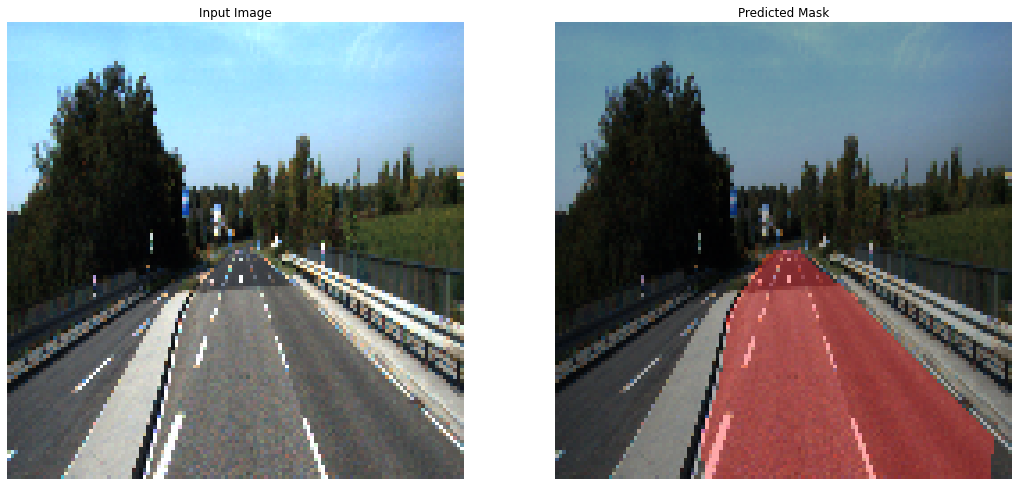

Processing image : 16
1/1 [==============================] - 0s 21ms/step


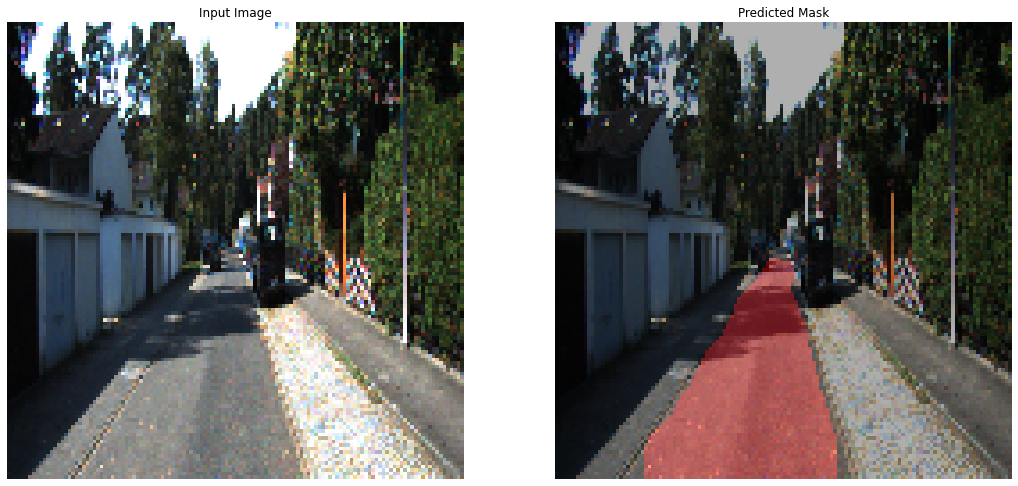

Processing image : 17
1/1 [==============================] - 0s 22ms/step


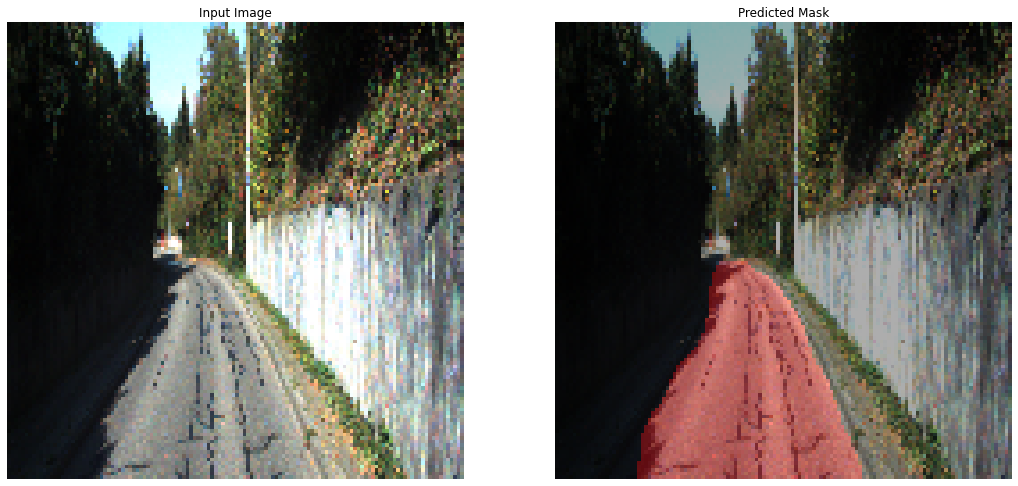

Processing image : 18
1/1 [==============================] - 0s 24ms/step


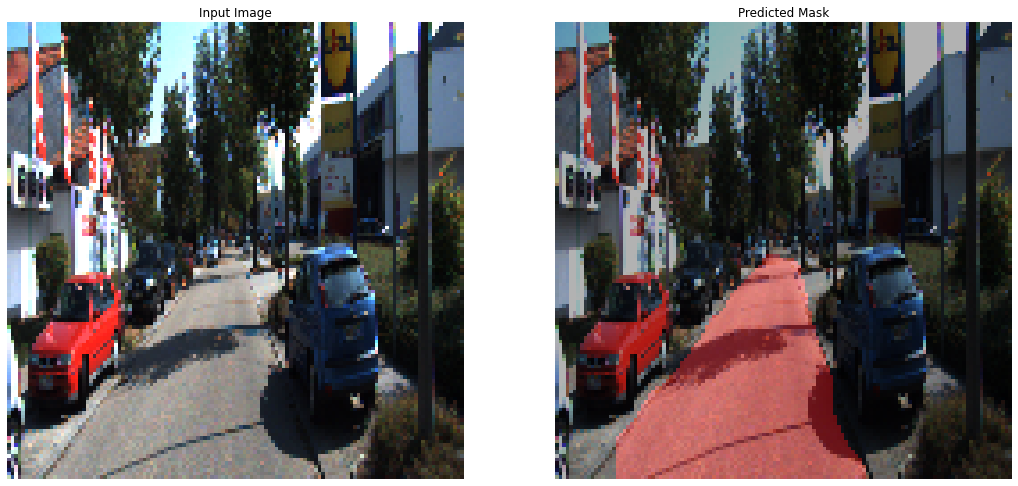

Processing image : 19
1/1 [==============================] - 0s 22ms/step


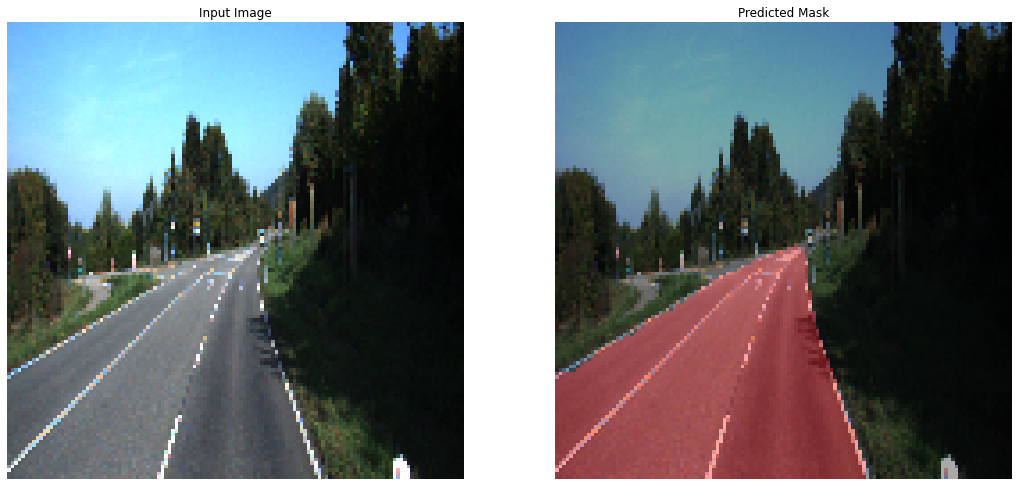

Processing image : 20
1/1 [==============================] - 0s 20ms/step


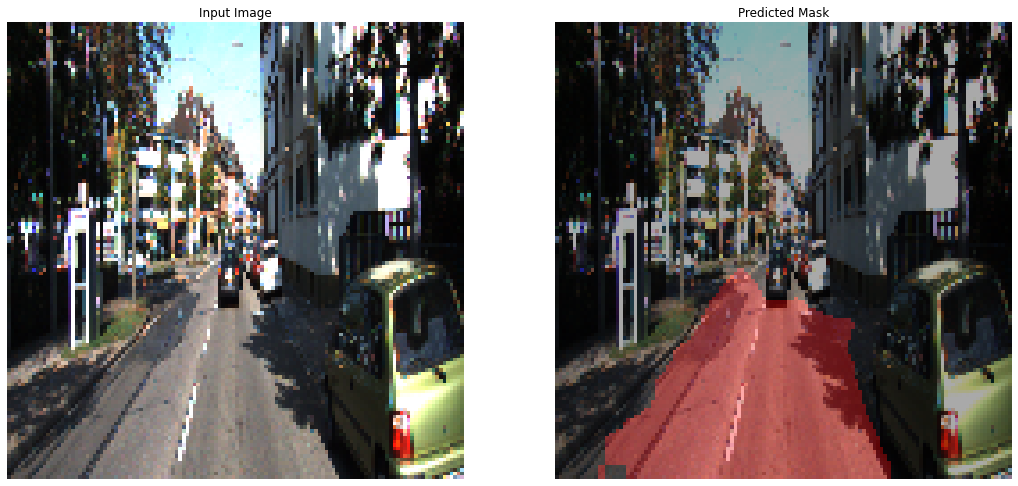

Processing image : 21
1/1 [==============================] - 0s 24ms/step


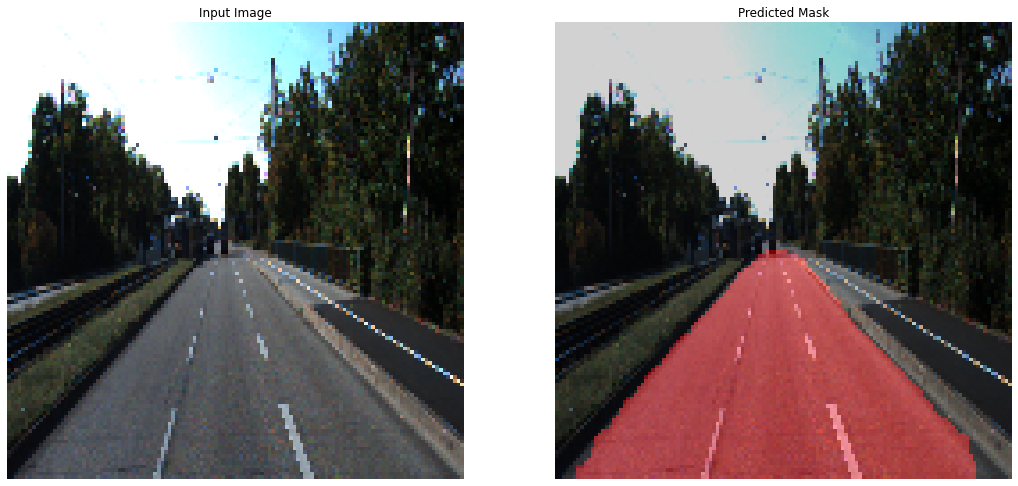

Processing image : 22
1/1 [==============================] - 0s 22ms/step


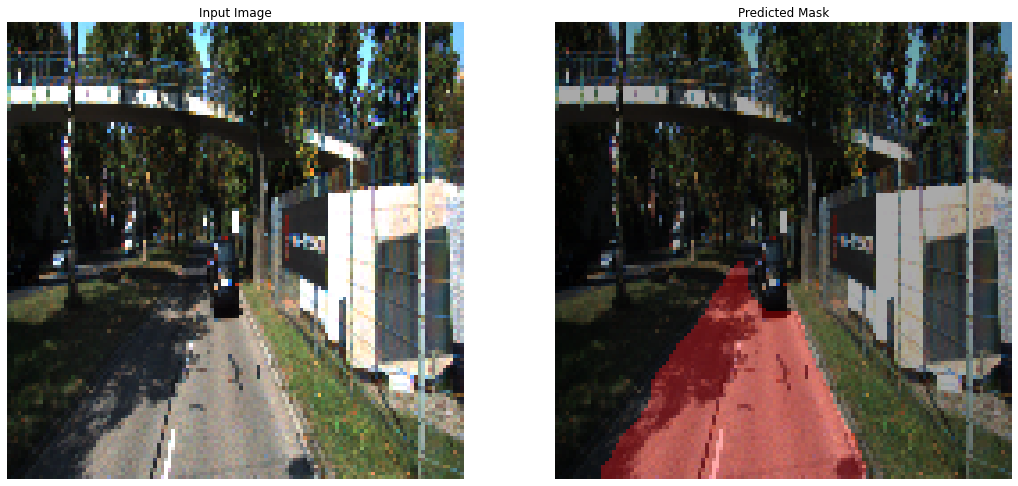

Processing image : 23
1/1 [==============================] - 0s 22ms/step


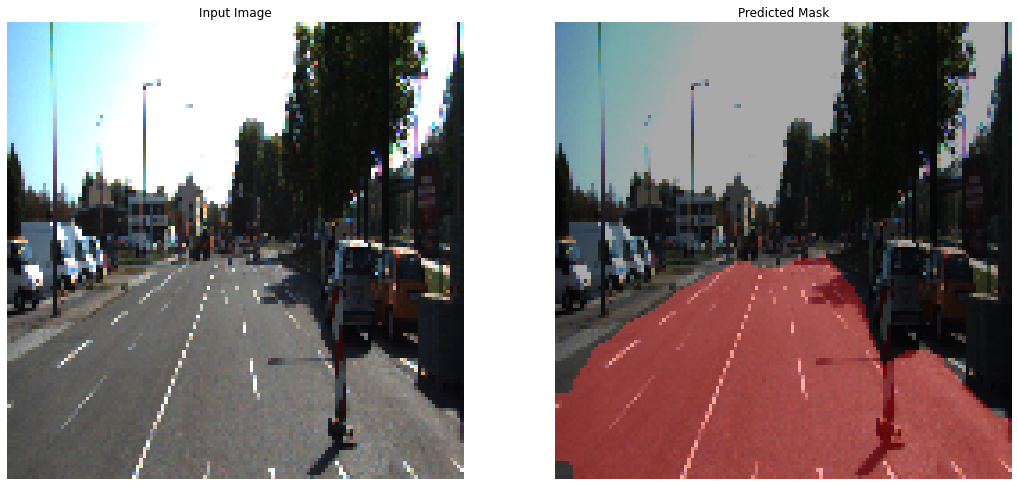

Processing image : 24
1/1 [==============================] - 0s 23ms/step


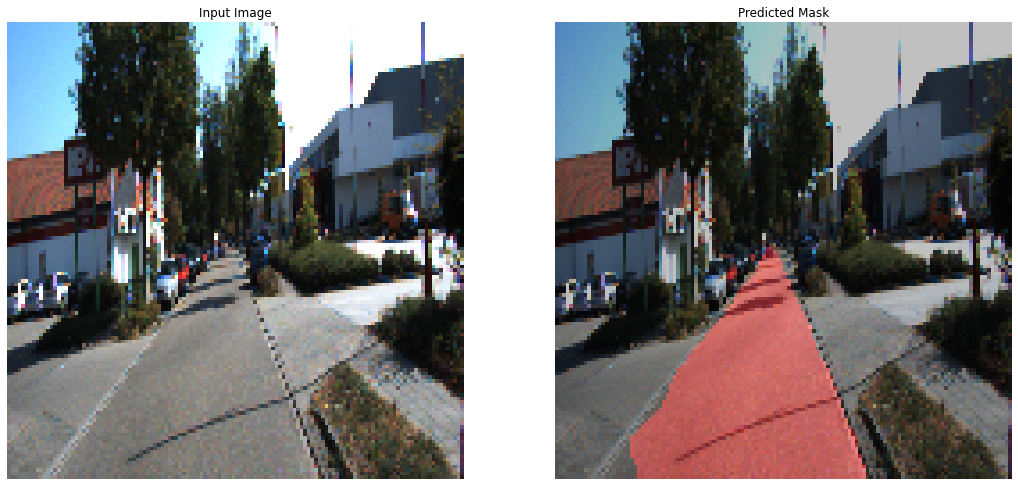

Processing image : 25
1/1 [==============================] - 0s 29ms/step


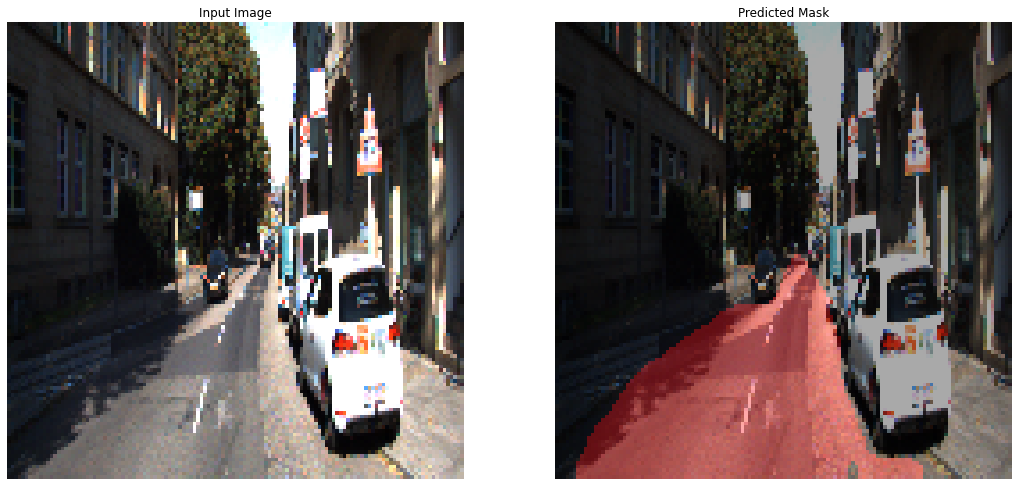

Processing image : 26
1/1 [==============================] - 0s 23ms/step


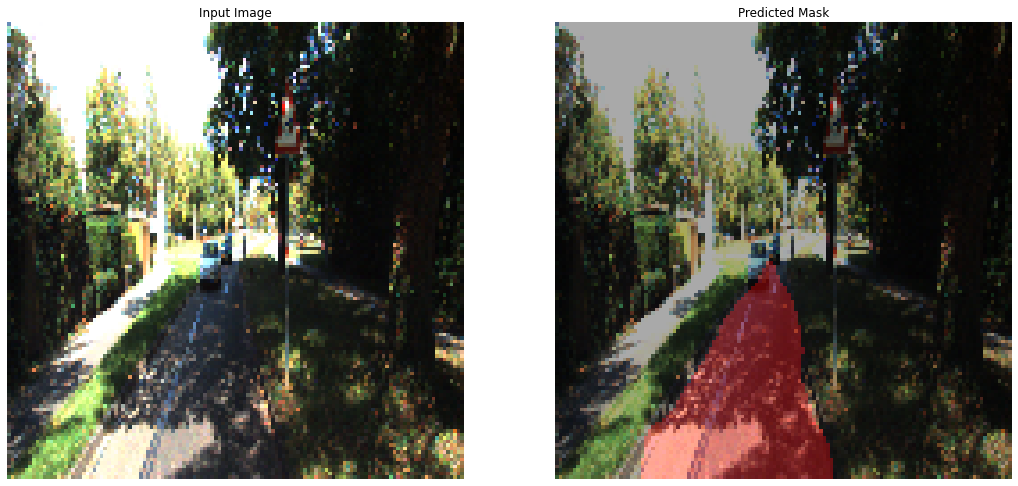

Processing image : 27
1/1 [==============================] - 0s 24ms/step


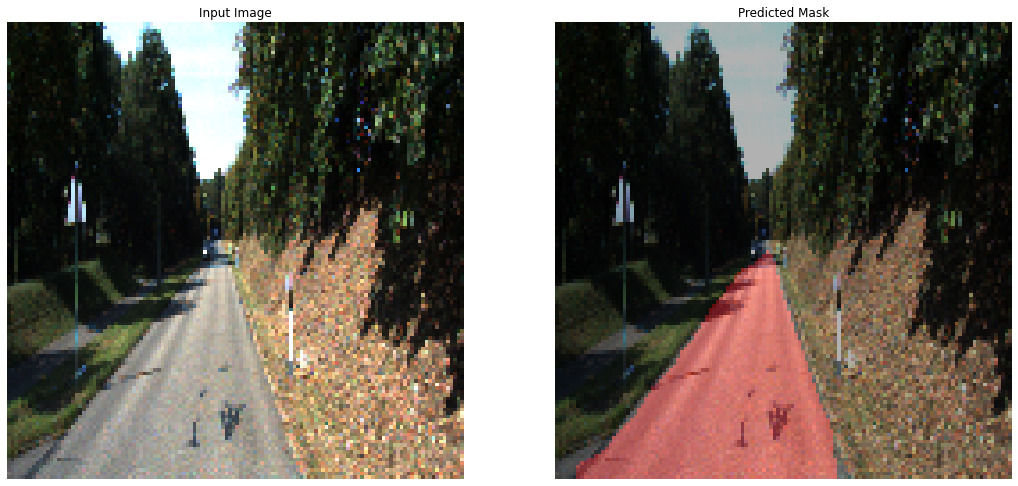

Processing image : 28
1/1 [==============================] - 0s 24ms/step


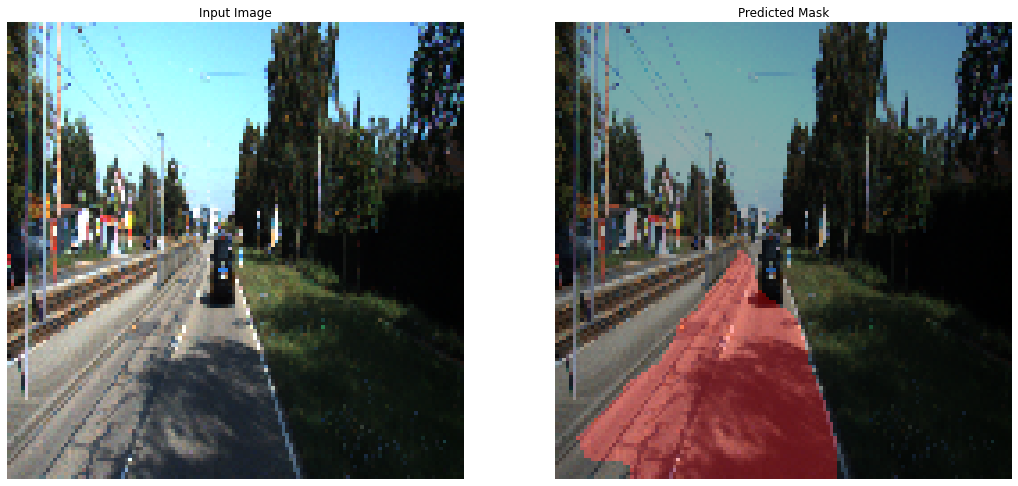

Processing image : 29
1/1 [==============================] - 0s 21ms/step


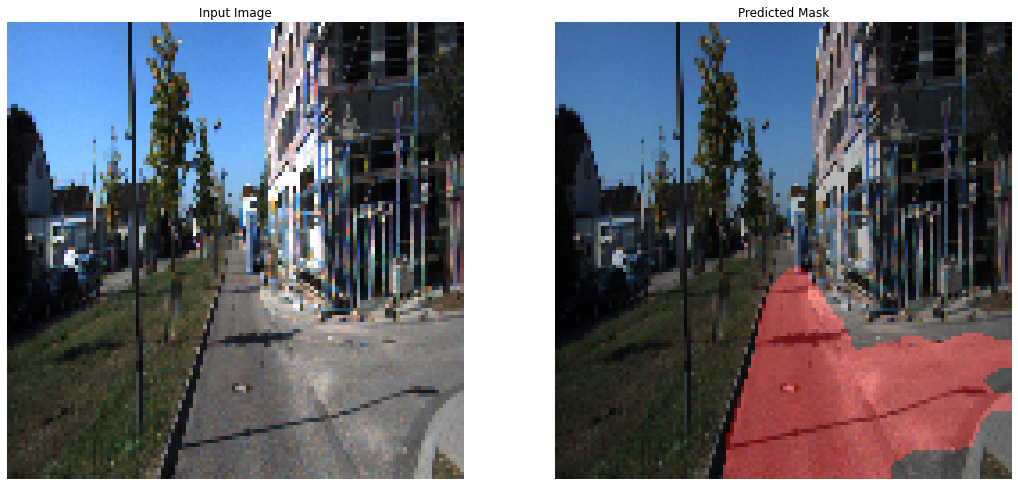

In [ ]:
os.mkdir("outputs")
save_predictions(dataset['test'])

In [ ]:
from google.colab import files

for i in range(30):
  files.download(f"/content/outputs/{i}.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing (Videos)

In [ ]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)
    
    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Make a new directory
os.mkdir("videos")

# **Project Video**

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "project_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3 ))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

1/1 [==============================] - 0s 17ms/step


In [ ]:
play("videos/" + project_video)